In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import optuna
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import QuantLib as ql
import mibian
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from copy import deepcopy
from keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Flatten, Dense, TimeDistributed, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from ta import add_all_ta_features
from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator
from tensorflow import keras
keras.utils.set_random_seed(812)
from sklearn.model_selection import KFold

C:\Users\unnia\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\unnia\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\unnia\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\unnia\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data preprocessing

In [2]:
# Read the data
df = pd.read_csv('data.csv')

## TSLA data preprocessing

In [3]:
df_TSLA = df[df['Stock_TSLA'] == 1.0]

# Calculate Simple Moving Average
df_TSLA['SMA'] = df_TSLA['UNDERLYING_LAST'].rolling(window=14).mean()

# Calculate Exponential Moving Average
df_TSLA['EMA'] = df_TSLA['UNDERLYING_LAST'].ewm(span=14, adjust=False).mean()

# Calculate RSI
df_TSLA['RSI'] = RSIIndicator(close=df_TSLA['UNDERLYING_LAST'], window=14).rsi()

# Calculate Bollinger Bands
indicator_bb = BollingerBands(close=df_TSLA['UNDERLYING_LAST'], window=20, window_dev=2)
df_TSLA['bb_bbm'] = indicator_bb.bollinger_mavg()
df_TSLA['bb_bbh'] = indicator_bb.bollinger_hband()
df_TSLA['bb_bbl'] = indicator_bb.bollinger_lband()

# Realized Volatility
df_TSLA['realized_vol'] = df_TSLA['UNDERLYING_LAST'].pct_change().rolling(window=14).std() * np.sqrt(252)


# For lagged features of the target variable, C_LAST:
df_TSLA['C_LAST_lag1'] = df_TSLA['C_LAST'].shift(1)
# For other variables, you could do the same:
df_TSLA['C_IV_lag1'] = df_TSLA['C_IV'].shift(1)


df_TSLA = df_TSLA[['C_IV_lag1','C_LAST_lag1','bb_bbm','bb_bbh','bb_bbl','SMA','EMA','RSI', 'realized_vol','UNDERLYING_LAST', 'STRIKE', 'DTE', 'C_IV', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT', 'interest rate', 'dividend_rate','C_LAST']]
df_TSLA = df_TSLA.dropna()

# Find indices where C_IV or DTE is zero
indices_to_remove = df_TSLA[(df_TSLA['C_IV'] == 0) | (df_TSLA['DTE'] == 0)].index

# Drop these indices from the DataFrame
df_TSLA = df_TSLA.drop(indices_to_remove)

# Reset the index
df_TSLA = df_TSLA.reset_index(drop=True)

C:\Users\unnia\AppData\Local\Temp\ipykernel_25328\2518326361.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TSLA['SMA'] = df_TSLA['UNDERLYING_LAST'].rolling(window=14).mean()
C:\Users\unnia\AppData\Local\Temp\ipykernel_25328\2518326361.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TSLA['EMA'] = df_TSLA['UNDERLYING_LAST'].ewm(span=14, adjust=False).mean()
C:\Users\unnia\AppData\Local\Temp\ipykernel_25328\2518326361.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [4]:
# Prepare the features and target variable
X_TSLA = df_TSLA[['C_IV_lag1','C_LAST_lag1','bb_bbm','bb_bbh','bb_bbl','SMA','EMA','RSI', 'realized_vol','UNDERLYING_LAST',  'STRIKE','DTE', 'C_IV', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT', 'interest rate','dividend_rate']].values
y_TSLA = df_TSLA['C_LAST'].values

In [5]:
# Define split points
train_split_TSLA = int(len(X_TSLA) * 0.7)  # 70% of the data for training
val_split_TSLA = int(len(X_TSLA) * 0.8)    

# Split the data into training, validation, and testing sets
X_train_TSLA, X_val_test_TSLA = X_TSLA[:train_split_TSLA], X_TSLA[train_split_TSLA:]
y_train_TSLA, y_val_test_TSLA = y_TSLA[:train_split_TSLA], y_TSLA[train_split_TSLA:]

# Split the remaining 30% into validation and test sets
val_size_TSLA = int(len(X_val_test_TSLA) * (10/30))  
X_val_TSLA, X_test_TSLA = X_val_test_TSLA[:val_size_TSLA], X_val_test_TSLA[val_size_TSLA:]
y_val_TSLA, y_test_TSLA = y_val_test_TSLA[:val_size_TSLA], y_val_test_TSLA[val_size_TSLA:]

## AAPL data preprocessing

In [6]:
df_AAPL = df[df['Stock_AAPL'] == 1.0]

# Calculate Simple Moving Average
df_AAPL['SMA'] = df_AAPL['UNDERLYING_LAST'].rolling(window=14).mean()

# Calculate Exponential Moving Average
df_AAPL['EMA'] = df_AAPL['UNDERLYING_LAST'].ewm(span=14, adjust=False).mean()

# Calculate RSI
df_AAPL['RSI'] = RSIIndicator(close=df_AAPL['UNDERLYING_LAST'], window=14).rsi()

# Calculate Bollinger Bands
indicator_bb = BollingerBands(close=df_AAPL['UNDERLYING_LAST'], window=20, window_dev=2)
df_AAPL['bb_bbm'] = indicator_bb.bollinger_mavg()
df_AAPL['bb_bbh'] = indicator_bb.bollinger_hband()
df_AAPL['bb_bbl'] = indicator_bb.bollinger_lband()

# Realized Volatility
df_AAPL['realized_vol'] = df_AAPL['UNDERLYING_LAST'].pct_change().rolling(window=14).std() * np.sqrt(252)


# For lagged features of the target variable, C_LAST:
df_AAPL['C_LAST_lag1'] = df_AAPL['C_LAST'].shift(1)
# For other variables, you could do the same:
df_AAPL['C_IV_lag1'] = df_AAPL['C_IV'].shift(1)


df_AAPL = df_AAPL[['C_IV_lag1','C_LAST_lag1','bb_bbm','bb_bbh','bb_bbl','SMA','EMA','RSI', 'realized_vol','UNDERLYING_LAST', 'STRIKE', 'DTE', 'C_IV', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT', 'interest rate','dividend_rate', 'C_LAST']]
df_AAPL = df_AAPL.dropna()

# Find indices where C_IV or DTE is zero
indices_to_remove = df_AAPL[(df_AAPL['C_IV'] == 0) | (df_AAPL['DTE'] == 0)].index

# Drop these indices from the DataFrame
df_AAPL = df_AAPL.drop(indices_to_remove)

# Reset the index
df_AAPL = df_AAPL.reset_index(drop=True)

C:\Users\unnia\AppData\Local\Temp\ipykernel_25328\2192086726.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_AAPL['SMA'] = df_AAPL['UNDERLYING_LAST'].rolling(window=14).mean()
C:\Users\unnia\AppData\Local\Temp\ipykernel_25328\2192086726.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_AAPL['EMA'] = df_AAPL['UNDERLYING_LAST'].ewm(span=14, adjust=False).mean()
C:\Users\unnia\AppData\Local\Temp\ipykernel_25328\2192086726.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [7]:
# Prepare the features and target variable
X_AAPL = df_AAPL[['C_IV_lag1','C_LAST_lag1','bb_bbm','bb_bbh','bb_bbl','SMA','EMA','RSI', 'realized_vol','UNDERLYING_LAST',  'STRIKE','DTE', 'C_IV', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT', 'interest rate','dividend_rate']].values
y_AAPL = df_AAPL['C_LAST'].values

In [8]:
# Define split points
train_split_AAPL = int(len(X_AAPL) * 0.7)  # 70% of the data for training
val_split_AAPL = int(len(X_AAPL) * 0.8)    

# Split the data into training, validation, and testing sets
X_train_AAPL, X_val_test_AAPL = X_AAPL[:train_split_AAPL], X_AAPL[train_split_AAPL:]
y_train_AAPL, y_val_test_AAPL = y_AAPL[:train_split_AAPL], y_AAPL[train_split_AAPL:]

# Split the remaining 30% into validation and test sets
val_size_AAPL = int(len(X_val_test_AAPL) * (10/30))  
X_val_AAPL, X_test_AAPL = X_val_test_AAPL[:val_size_AAPL], X_val_test_AAPL[val_size_AAPL:]
y_val_AAPL, y_test_AAPL = y_val_test_AAPL[:val_size_AAPL], y_val_test_AAPL[val_size_AAPL:]

## NVDA data preprocessing

In [9]:
df_NVDA = df[df['Stock_NVDA'] == 1.0]

# Calculate Simple Moving Average
df_NVDA['SMA'] = df_NVDA['UNDERLYING_LAST'].rolling(window=14).mean()

# Calculate Exponential Moving Average
df_NVDA['EMA'] = df_NVDA['UNDERLYING_LAST'].ewm(span=14, adjust=False).mean()

# Calculate RSI
df_NVDA['RSI'] = RSIIndicator(close=df_NVDA['UNDERLYING_LAST'], window=14).rsi()

# Calculate Bollinger Bands
indicator_bb = BollingerBands(close=df_NVDA['UNDERLYING_LAST'], window=20, window_dev=2)
df_NVDA['bb_bbm'] = indicator_bb.bollinger_mavg()
df_NVDA['bb_bbh'] = indicator_bb.bollinger_hband()
df_NVDA['bb_bbl'] = indicator_bb.bollinger_lband()

# Realized Volatility
df_NVDA['realized_vol'] = df_NVDA['UNDERLYING_LAST'].pct_change().rolling(window=14).std() * np.sqrt(252)


# For lagged features of the target variable, C_LAST:
df_NVDA['C_LAST_lag1'] = df_NVDA['C_LAST'].shift(1)
# For other variables, you could do the same:
df_NVDA['C_IV_lag1'] = df_NVDA['C_IV'].shift(1)


df_NVDA = df_NVDA[['C_IV_lag1','C_LAST_lag1','bb_bbm','bb_bbh','bb_bbl','SMA','EMA','RSI', 'realized_vol','UNDERLYING_LAST', 'STRIKE', 'DTE', 'C_IV', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT', 'interest rate','dividend_rate', 'C_LAST']]
df_NVDA = df_NVDA.dropna()

# Find indices where C_IV or DTE is zero
indices_to_remove = df_NVDA[(df_NVDA['C_IV'] == 0) | (df_NVDA['DTE'] == 0)].index

# Drop these indices from the DataFrame
df_NVDA = df_NVDA.drop(indices_to_remove)

# Reset the index
df_NVDA = df_NVDA.reset_index(drop=True)

C:\Users\unnia\AppData\Local\Temp\ipykernel_25328\1211373322.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA['SMA'] = df_NVDA['UNDERLYING_LAST'].rolling(window=14).mean()
C:\Users\unnia\AppData\Local\Temp\ipykernel_25328\1211373322.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA['EMA'] = df_NVDA['UNDERLYING_LAST'].ewm(span=14, adjust=False).mean()
C:\Users\unnia\AppData\Local\Temp\ipykernel_25328\1211373322.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [10]:
# Prepare the features and target variable
X_NVDA = df_NVDA[['C_IV_lag1','C_LAST_lag1','bb_bbm','bb_bbh','bb_bbl','SMA','EMA','RSI', 'realized_vol','UNDERLYING_LAST',  'STRIKE','DTE', 'C_IV', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT', 'interest rate','dividend_rate']].values
y_NVDA = df_NVDA['C_LAST'].values

In [11]:
# Define split points
train_split_NVDA = int(len(X_NVDA) * 0.7)  # 70% of the data for training
val_split_NVDA = int(len(X_NVDA) * 0.8)    

# Split the data into training, validation, and testing sets
X_train_NVDA, X_val_test_NVDA = X_NVDA[:train_split_NVDA], X_NVDA[train_split_NVDA:]
y_train_NVDA, y_val_test_NVDA = y_NVDA[:train_split_NVDA], y_NVDA[train_split_NVDA:]

# Split the remaining 30% into validation and test sets
val_size_NVDA = int(len(X_val_test_NVDA) * (10/30))  
X_val_NVDA, X_test_NVDA = X_val_test_NVDA[:val_size_NVDA], X_val_test_NVDA[val_size_NVDA:]
y_val_NVDA, y_test_NVDA = y_val_test_NVDA[:val_size_NVDA], y_val_test_NVDA[val_size_NVDA:]

### Features

In [12]:
# Select features to use for prediction
features = ['C_IV_lag1','C_LAST_lag1','bb_bbm','bb_bbh','bb_bbl','SMA','EMA','RSI', 'realized_vol', 'UNDERLYING_LAST', 'STRIKE', 'DTE', 'C_IV', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT', 'interest rate','dividend_rate']
target = 'C_LAST'

# Barone-Adesi and Whaley Approximation

In [13]:
def compute_american_option(row, option_type='call'):
    # Extract parameters from the row
    underlying_price = row['UNDERLYING_LAST']
    strike_price = row['STRIKE']
    interest_rate = row['interest rate'] / 100  # Convert to decimal
    days_to_expiration = row['DTE']
    volatility = row['C_IV'] / 100  # Convert to decimal
    dividend_rate = row['dividend_rate']  # Assuming no dividends, adjust if you have dividend rates

    # Setup the calculation date
    calculation_date = ql.Date.todaysDate()
    ql.Settings.instance().evaluationDate = calculation_date

    # Option data
    maturity_date = calculation_date + int(days_to_expiration)
    day_count = ql.Actual365Fixed()
    calendar = ql.UnitedStates(ql.UnitedStates.NYSE)

    # Option type
    if option_type.lower() == 'call':
        option_type = ql.Option.Call
    else:
        option_type = ql.Option.Put

    # Construct the European Option
    payoff = ql.PlainVanillaPayoff(option_type, strike_price)
    exercise = ql.AmericanExercise(calculation_date, maturity_date)
    american_option = ql.VanillaOption(payoff, exercise)

    # Construct the Black-Scholes-Merton process
    spot_handle = ql.QuoteHandle(ql.SimpleQuote(underlying_price))
    flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, interest_rate, day_count))
    dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, dividend_rate, day_count))
    flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calculation_date, calendar, volatility, day_count))
    bsm_process = ql.BlackScholesMertonProcess(spot_handle, dividend_yield, flat_ts, flat_vol_ts)

    # Setup the engine and calculate
    engine = ql.BaroneAdesiWhaleyApproximationEngine(bsm_process)
    american_option.setPricingEngine(engine)

    return american_option.NPV()

## Barone-Adesi and Whaley Approximation for TSLA

In [14]:
# Apply the function to the DataFrame
X_test_df_TSLA = pd.DataFrame(X_test_TSLA, columns=['C_IV_lag1','C_LAST_lag1','bb_bbm','bb_bbh','bb_bbl','SMA','EMA','RSI', 'realized_vol','UNDERLYING_LAST',  'STRIKE','DTE', 'C_IV', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT', 'interest rate','dividend_rate'])
X_test_df_TSLA['BlackScholesPrice'] = X_test_df_TSLA.apply(compute_american_option, axis=1)

# Get the predicted Black-Scholes prices
predicted_prices_TSLA = X_test_df_TSLA['BlackScholesPrice'].values

# Compute the RMSE for Black Sholes Method
rmse_TSLA = mean_squared_error(y_test_TSLA, predicted_prices_TSLA, squared=False)
print(f"RMSE for TSLA dataset: {rmse_TSLA}")

RMSE for TSLA dataset: 21.12744626008425


## Barone-Adesi and Whaley Approximation for AAPL

In [15]:
# Apply the function to the DataFrame
X_test_df_AAPL = pd.DataFrame(X_test_AAPL, columns=['C_IV_lag1','C_LAST_lag1','bb_bbm','bb_bbh','bb_bbl','SMA','EMA','RSI', 'realized_vol','UNDERLYING_LAST',  'STRIKE','DTE', 'C_IV', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT', 'interest rate','dividend_rate'])
X_test_df_AAPL['BlackScholesPrice'] = X_test_df_AAPL.apply(compute_american_option, axis=1)

# Get the predicted Black-Scholes prices
predicted_prices_AAPL = X_test_df_AAPL['BlackScholesPrice'].values

# Compute the RMSE for Black Sholes Method
rmse_AAPL = mean_squared_error(y_test_AAPL, predicted_prices_AAPL, squared=False)
print(f"RMSE for AAPL dataset: {rmse_AAPL}")

RMSE for AAPL dataset: 6.941820707584086


## Barone-Adesi and Whaley Approximation for NVDA

In [16]:
# Apply the function to the DataFrame
X_test_df_NVDA = pd.DataFrame(X_test_NVDA, columns=['C_IV_lag1','C_LAST_lag1','bb_bbm','bb_bbh','bb_bbl','SMA','EMA','RSI', 'realized_vol','UNDERLYING_LAST',  'STRIKE','DTE', 'C_IV', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT', 'interest rate','dividend_rate'])
X_test_df_NVDA['BlackScholesPrice'] = X_test_df_NVDA.apply(compute_american_option, axis=1)

# Get the predicted Black-Scholes prices
predicted_prices_NVDA = X_test_df_NVDA['BlackScholesPrice'].values

# Compute the RMSE for Black Sholes Method
rmse_NVDA = mean_squared_error(y_test_NVDA, predicted_prices_NVDA, squared=False)
print(f"RMSE for NVDA dataset: {rmse_NVDA}")

RMSE for NVDA dataset: 44.93740398284506


# Feedforward Neural Network

## Scaling and Converting to Tensor

### TSLA

In [17]:
# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train_TSLA)

# Scale the training data
X_train_TSLA_scaled = scaler.transform(X_train_TSLA)

# Scale the validation data
X_val_TSLA_scaled = scaler.transform(X_val_TSLA)

# Scale the test data
X_test_TSLA_scaled = scaler.transform(X_test_TSLA)

# Convert the scaled data to tensors
X_train_TSLA_tensor = torch.tensor(X_train_TSLA_scaled, dtype=torch.float32)
y_train_TSLA_tensor = torch.tensor(y_train_TSLA, dtype=torch.float32).unsqueeze(1)

X_val_TSLA_tensor = torch.tensor(X_val_TSLA_scaled, dtype=torch.float32)
y_val_TSLA_tensor = torch.tensor(y_val_TSLA, dtype=torch.float32).unsqueeze(1)

X_test_TSLA_tensor = torch.tensor(X_test_TSLA_scaled, dtype=torch.float32)
y_test_TSLA_tensor = torch.tensor(y_test_TSLA, dtype=torch.float32).unsqueeze(1)

### AAPL

In [18]:
# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train_AAPL)

# Scale the training data
X_train_AAPL_scaled = scaler.transform(X_train_AAPL)

# Scale the validation data
X_val_AAPL_scaled = scaler.transform(X_val_AAPL)

# Scale the test data
X_test_AAPL_scaled = scaler.transform(X_test_AAPL)

# Convert the scaled data to tensors
X_train_AAPL_tensor = torch.tensor(X_train_AAPL_scaled, dtype=torch.float32)
y_train_AAPL_tensor = torch.tensor(y_train_AAPL, dtype=torch.float32).unsqueeze(1)

X_val_AAPL_tensor = torch.tensor(X_val_AAPL_scaled, dtype=torch.float32)
y_val_AAPL_tensor = torch.tensor(y_val_AAPL, dtype=torch.float32).unsqueeze(1)

X_test_AAPL_tensor = torch.tensor(X_test_AAPL_scaled, dtype=torch.float32)
y_test_AAPL_tensor = torch.tensor(y_test_AAPL, dtype=torch.float32).unsqueeze(1)

### NVDA

In [19]:
# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train_NVDA)

# Scale the training data
X_train_NVDA_scaled = scaler.transform(X_train_NVDA)

# Scale the validation data
X_val_NVDA_scaled = scaler.transform(X_val_NVDA)

# Scale the test data
X_test_NVDA_scaled = scaler.transform(X_test_NVDA)

# Convert the scaled data to tensors
X_train_NVDA_tensor = torch.tensor(X_train_NVDA_scaled, dtype=torch.float32)
y_train_NVDA_tensor = torch.tensor(y_train_NVDA, dtype=torch.float32).unsqueeze(1)

X_val_NVDA_tensor = torch.tensor(X_val_NVDA_scaled, dtype=torch.float32)
y_val_NVDA_tensor = torch.tensor(y_val_NVDA, dtype=torch.float32).unsqueeze(1)

X_test_NVDA_tensor = torch.tensor(X_test_NVDA_scaled, dtype=torch.float32)
y_test_NVDA_tensor = torch.tensor(y_test_NVDA, dtype=torch.float32).unsqueeze(1)

### Train Function

In [20]:
# Train the model with early stopping
def train(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, loss_fn, optimizer, epochs=100, batch_size=64, patience=10):
    train_losses = []
    val_losses = []
    best_loss = float('inf')
    best_model = None
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for i in range(0, len(X_train_tensor), batch_size):
            # Get the minibatch
            X_batch = X_train_tensor[i:i+batch_size]
            y_batch = y_train_tensor[i:i+batch_size]

            # Forward pass
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            
            epoch_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
        
        # Average loss for this epoch
        avg_epoch_loss = epoch_loss / (len(X_train_tensor) / batch_size)
        train_losses.append(avg_epoch_loss)

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_predictions = model(X_val_tensor)
            val_loss = loss_fn(val_predictions, y_val_tensor).item()
            val_losses.append(val_loss)

        # Print training and validation loss
        print(f'Epoch {epoch+1}/{epochs} - Loss: {loss.item()}, Val Loss: {val_loss}')

        # Check for early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = deepcopy(model.state_dict())  # Save a copy of the model
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print('Early stopping triggered')
            break

    # Load the best model state
    model.load_state_dict(best_model)
    return model, train_losses, val_losses

### Test Function

In [21]:
# Test the model
def test(model, X_test_tensor, y_test_tensor):
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
        y_pred = y_pred_tensor.numpy().squeeze()
        y_test_original = y_test_tensor.numpy().squeeze() 
        rmse = mean_squared_error(y_test_original, y_pred, squared=False)
        print(f'Root Mean Squared Error (RMSE): {rmse}')
        return rmse

# Find Best FNN Model

In [22]:
class BaseNN(nn.Module):
    def __init__(self, no_features, hidden_dims, activation='relu'):
        super(BaseNN, self).__init__()
        layers = []
        input_dim = no_features
        # Define a dictionary to map activation names to their functions
        activations = {
            'relu': nn.ReLU(),
            'leaky_relu': nn.LeakyReLU()
        }
        # Get the selected activation function from the dictionary
        self.activation = activations[activation]
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(self.activation)  # Use the selected activation function
            input_dim = hidden_dim  # Set the input for the next layer
        layers.append(nn.Linear(input_dim, 1))  # Output layer
        self.mlp_stack = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.mlp_stack(x)
        return logits

In [29]:
hidden_dims_list = [[10], [128], [128, 128]]
batch_sizes = [32, 64]
activation_functions = ['relu', 'leaky_relu']

# Keep track of experiments
experiment_log = []

# Cross-validation setup
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Hyperparameter search loop
for hidden_dims in hidden_dims_list:
    for batch_size in batch_sizes:
        for activation in activation_functions:
            # Cross-validation scores
            cv_scores = []
            
            for train_index, val_index in kf.split(X_train_TSLA_tensor):
                # Split the data into current training and validation sets for this fold
                X_train_fold, X_val_fold = X_train_TSLA_tensor[train_index], X_train_TSLA_tensor[val_index]
                y_train_fold, y_val_fold = y_train_TSLA_tensor[train_index], y_train_TSLA_tensor[val_index]
                
                # Initialize model, loss, and optimizer
                model = BaseNN(X_train_fold.shape[1], hidden_dims, activation)
                criterion = nn.MSELoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)
                
                # Train the model on the current fold
                model = train(model, X_train_fold, y_train_fold, X_val_fold, y_val_fold, criterion, optimizer, epochs=100, batch_size=batch_size)
                
                # Evaluate the model on the current validation fold
                val_rmse = test(model, X_val_fold, y_val_fold)
                cv_scores.append(val_rmse)
            
            # Compute the average RMSE over all folds
            average_rmse = np.mean(cv_scores)
            
            # Log the experiment
            experiment_log.append({
                'hidden_dims': hidden_dims,
                'batch_size': batch_size,
                'learning_rate': 0.001,
                'activation': activation,
                'cv_rmse': average_rmse
            })

Epoch 1/100 - Loss: 12836.271484375, Val Loss: 664.485595703125
Epoch 2/100 - Loss: 2084.982177734375, Val Loss: 328.3521423339844
Epoch 3/100 - Loss: 1057.62109375, Val Loss: 242.59222412109375
Epoch 4/100 - Loss: 782.8485717773438, Val Loss: 193.63211059570312
Epoch 5/100 - Loss: 657.555908203125, Val Loss: 170.39654541015625
Epoch 6/100 - Loss: 612.4159545898438, Val Loss: 159.15834045410156
Epoch 7/100 - Loss: 648.5150146484375, Val Loss: 152.8344268798828
Epoch 8/100 - Loss: 718.7825317382812, Val Loss: 149.2294158935547
Epoch 9/100 - Loss: 753.514892578125, Val Loss: 147.4657440185547
Epoch 10/100 - Loss: 782.74609375, Val Loss: 146.257568359375
Epoch 11/100 - Loss: 825.372314453125, Val Loss: 145.0177764892578
Epoch 12/100 - Loss: 864.65576171875, Val Loss: 144.0819091796875
Epoch 13/100 - Loss: 896.0657348632812, Val Loss: 143.4281005859375
Epoch 14/100 - Loss: 959.3167724609375, Val Loss: 142.7875518798828
Epoch 15/100 - Loss: 1008.3289794921875, Val Loss: 141.64405822753906
E

Epoch 39/100 - Loss: 2549.060546875, Val Loss: 130.6299285888672
Epoch 40/100 - Loss: 2545.250732421875, Val Loss: 130.53067016601562
Epoch 41/100 - Loss: 2544.93701171875, Val Loss: 130.43199157714844
Epoch 42/100 - Loss: 2544.7529296875, Val Loss: 130.33905029296875
Epoch 43/100 - Loss: 2542.87890625, Val Loss: 130.2485809326172
Epoch 44/100 - Loss: 2542.42822265625, Val Loss: 130.16673278808594
Epoch 45/100 - Loss: 2542.2734375, Val Loss: 130.09535217285156
Epoch 46/100 - Loss: 2543.4697265625, Val Loss: 130.0165557861328
Epoch 47/100 - Loss: 2544.8818359375, Val Loss: 129.9248504638672
Epoch 48/100 - Loss: 2543.6220703125, Val Loss: 129.83360290527344
Epoch 49/100 - Loss: 2543.495849609375, Val Loss: 129.7232208251953
Epoch 50/100 - Loss: 2546.76416015625, Val Loss: 129.64910888671875
Epoch 51/100 - Loss: 2547.39892578125, Val Loss: 129.52577209472656
Epoch 52/100 - Loss: 2549.91162109375, Val Loss: 129.42672729492188
Epoch 53/100 - Loss: 2550.30712890625, Val Loss: 129.29287719726

Epoch 7/100 - Loss: 1958.966552734375, Val Loss: 182.6675262451172
Epoch 8/100 - Loss: 2072.84765625, Val Loss: 177.6640625
Epoch 9/100 - Loss: 2142.71923828125, Val Loss: 173.80172729492188
Epoch 10/100 - Loss: 2199.609375, Val Loss: 170.99172973632812
Epoch 11/100 - Loss: 2255.80615234375, Val Loss: 168.67263793945312
Epoch 12/100 - Loss: 2269.62060546875, Val Loss: 167.0095977783203
Epoch 13/100 - Loss: 2284.139892578125, Val Loss: 164.84979248046875
Epoch 14/100 - Loss: 2296.390625, Val Loss: 163.09713745117188
Epoch 15/100 - Loss: 2305.371337890625, Val Loss: 161.6893768310547
Epoch 16/100 - Loss: 2248.873046875, Val Loss: 160.08294677734375
Epoch 17/100 - Loss: 2220.56689453125, Val Loss: 158.70654296875
Epoch 18/100 - Loss: 2205.052978515625, Val Loss: 157.5983123779297
Epoch 19/100 - Loss: 2195.73974609375, Val Loss: 156.75927734375
Epoch 20/100 - Loss: 2191.4296875, Val Loss: 156.05967712402344
Epoch 21/100 - Loss: 2182.970947265625, Val Loss: 155.47381591796875
Epoch 22/100 -

Epoch 68/100 - Loss: 932.3463745117188, Val Loss: 111.30538177490234
Epoch 69/100 - Loss: 926.9542236328125, Val Loss: 111.07622528076172
Epoch 70/100 - Loss: 918.8837280273438, Val Loss: 110.84688568115234
Epoch 71/100 - Loss: 912.9395751953125, Val Loss: 110.6319808959961
Epoch 72/100 - Loss: 907.5597534179688, Val Loss: 110.42729949951172
Epoch 73/100 - Loss: 903.6713256835938, Val Loss: 110.22714233398438
Epoch 74/100 - Loss: 900.5759887695312, Val Loss: 110.05990600585938
Epoch 75/100 - Loss: 897.3414306640625, Val Loss: 109.86690521240234
Epoch 76/100 - Loss: 894.6192626953125, Val Loss: 109.70195770263672
Epoch 77/100 - Loss: 892.3023071289062, Val Loss: 109.5456314086914
Epoch 78/100 - Loss: 878.5874633789062, Val Loss: 109.40902709960938
Epoch 79/100 - Loss: 878.3269653320312, Val Loss: 109.27947998046875
Epoch 80/100 - Loss: 877.4254760742188, Val Loss: 109.1584701538086
Epoch 81/100 - Loss: 875.967041015625, Val Loss: 109.07102966308594
Epoch 82/100 - Loss: 875.9273071289062

Epoch 89/100 - Loss: 2804.529541015625, Val Loss: 119.3267822265625
Epoch 90/100 - Loss: 2791.7412109375, Val Loss: 119.43229675292969
Early stopping triggered
Root Mean Squared Error (RMSE): 10.899765968322754
Epoch 1/100 - Loss: 75.22699737548828, Val Loss: 528.4171142578125
Epoch 2/100 - Loss: 602.8724365234375, Val Loss: 342.9620361328125
Epoch 3/100 - Loss: 1166.30712890625, Val Loss: 281.6964416503906
Epoch 4/100 - Loss: 1409.641845703125, Val Loss: 242.0643310546875
Epoch 5/100 - Loss: 1590.119384765625, Val Loss: 216.2943878173828
Epoch 6/100 - Loss: 1728.014404296875, Val Loss: 200.17071533203125
Epoch 7/100 - Loss: 1831.742919921875, Val Loss: 190.4556427001953
Epoch 8/100 - Loss: 1909.817626953125, Val Loss: 184.48611450195312
Epoch 9/100 - Loss: 1969.490478515625, Val Loss: 180.57603454589844
Epoch 10/100 - Loss: 2015.9344482421875, Val Loss: 177.73159790039062
Epoch 11/100 - Loss: 2052.796142578125, Val Loss: 175.49305725097656
Epoch 12/100 - Loss: 2082.489501953125, Val L

Epoch 59/100 - Loss: 2249.365234375, Val Loss: 150.5388641357422
Epoch 60/100 - Loss: 2245.81005859375, Val Loss: 150.61859130859375
Epoch 61/100 - Loss: 2244.917236328125, Val Loss: 150.6454315185547
Epoch 62/100 - Loss: 2238.37646484375, Val Loss: 150.6644287109375
Epoch 63/100 - Loss: 2237.769775390625, Val Loss: 150.72512817382812
Epoch 64/100 - Loss: 2231.42236328125, Val Loss: 150.73353576660156
Epoch 65/100 - Loss: 2228.2275390625, Val Loss: 150.7729949951172
Early stopping triggered
Root Mean Squared Error (RMSE): 12.262642860412598
Epoch 1/100 - Loss: 9.951979637145996, Val Loss: 437.4568176269531
Epoch 2/100 - Loss: 927.4735107421875, Val Loss: 287.9911193847656
Epoch 3/100 - Loss: 1352.1304931640625, Val Loss: 242.5462188720703
Epoch 4/100 - Loss: 1589.499267578125, Val Loss: 212.2196807861328
Epoch 5/100 - Loss: 1772.15673828125, Val Loss: 194.4518280029297
Epoch 6/100 - Loss: 1927.5595703125, Val Loss: 184.2219696044922
Epoch 7/100 - Loss: 2043.0142822265625, Val Loss: 178

Epoch 49/100 - Loss: 1053.1478271484375, Val Loss: 111.63469696044922
Epoch 50/100 - Loss: 1044.423095703125, Val Loss: 111.41521453857422
Epoch 51/100 - Loss: 1037.638916015625, Val Loss: 111.24629974365234
Epoch 52/100 - Loss: 1029.2713623046875, Val Loss: 111.08429718017578
Epoch 53/100 - Loss: 1021.4351806640625, Val Loss: 110.90678405761719
Epoch 54/100 - Loss: 1013.8572998046875, Val Loss: 110.71337890625
Epoch 55/100 - Loss: 1000.7612915039062, Val Loss: 110.60980987548828
Epoch 56/100 - Loss: 994.600830078125, Val Loss: 110.44435119628906
Epoch 57/100 - Loss: 987.3696899414062, Val Loss: 110.41128540039062
Epoch 58/100 - Loss: 984.1924438476562, Val Loss: 110.31250762939453
Epoch 59/100 - Loss: 976.9430541992188, Val Loss: 110.26033782958984
Epoch 60/100 - Loss: 970.920166015625, Val Loss: 110.18489837646484
Epoch 61/100 - Loss: 964.2286987304688, Val Loss: 110.1103515625
Epoch 62/100 - Loss: 955.7886962890625, Val Loss: 110.0354232788086
Epoch 63/100 - Loss: 950.1992797851562,

Epoch 69/100 - Loss: 2701.26806640625, Val Loss: 131.2628936767578
Epoch 70/100 - Loss: 2702.64501953125, Val Loss: 131.12985229492188
Epoch 71/100 - Loss: 2701.27587890625, Val Loss: 130.88528442382812
Epoch 72/100 - Loss: 2703.5302734375, Val Loss: 130.7525634765625
Epoch 73/100 - Loss: 2702.09912109375, Val Loss: 130.55711364746094
Epoch 74/100 - Loss: 2705.504638671875, Val Loss: 130.4008331298828
Epoch 75/100 - Loss: 2708.3212890625, Val Loss: 130.22792053222656
Epoch 76/100 - Loss: 2696.586181640625, Val Loss: 129.9429168701172
Epoch 77/100 - Loss: 2697.237548828125, Val Loss: 129.7650146484375
Epoch 78/100 - Loss: 2698.524658203125, Val Loss: 129.57728576660156
Epoch 79/100 - Loss: 2697.402587890625, Val Loss: 129.38473510742188
Epoch 80/100 - Loss: 2691.457275390625, Val Loss: 129.1767120361328
Epoch 81/100 - Loss: 2693.99267578125, Val Loss: 129.0413360595703
Epoch 82/100 - Loss: 2694.974853515625, Val Loss: 128.8794708251953
Epoch 83/100 - Loss: 2696.120361328125, Val Loss: 1

Epoch 30/100 - Loss: 2484.6669921875, Val Loss: 138.0917205810547
Epoch 31/100 - Loss: 2483.540283203125, Val Loss: 136.6890411376953
Epoch 32/100 - Loss: 2474.65283203125, Val Loss: 135.62611389160156
Epoch 33/100 - Loss: 2487.94873046875, Val Loss: 135.0787353515625
Epoch 34/100 - Loss: 2486.95703125, Val Loss: 134.66737365722656
Epoch 35/100 - Loss: 2488.7255859375, Val Loss: 134.59030151367188
Epoch 36/100 - Loss: 2481.578125, Val Loss: 134.600830078125
Epoch 37/100 - Loss: 2486.44189453125, Val Loss: 134.92991638183594
Epoch 38/100 - Loss: 2497.2802734375, Val Loss: 135.4026641845703
Epoch 39/100 - Loss: 2507.48681640625, Val Loss: 135.95599365234375
Epoch 40/100 - Loss: 2504.6455078125, Val Loss: 136.38082885742188
Epoch 41/100 - Loss: 2504.455078125, Val Loss: 136.8439178466797
Epoch 42/100 - Loss: 2503.703369140625, Val Loss: 137.3284912109375
Epoch 43/100 - Loss: 2506.8388671875, Val Loss: 137.8692626953125
Epoch 44/100 - Loss: 2510.2197265625, Val Loss: 138.36587524414062
Epo

Epoch 72/100 - Loss: 1137.808349609375, Val Loss: 137.53733825683594
Epoch 73/100 - Loss: 1138.7535400390625, Val Loss: 137.5469207763672
Early stopping triggered
Root Mean Squared Error (RMSE): 11.721660614013672
Epoch 1/100 - Loss: 1009.97705078125, Val Loss: 928.4146118164062
Epoch 2/100 - Loss: 71.97012329101562, Val Loss: 376.9856872558594
Epoch 3/100 - Loss: 569.8414916992188, Val Loss: 272.0054016113281
Epoch 4/100 - Loss: 923.9249267578125, Val Loss: 227.47512817382812
Epoch 5/100 - Loss: 1148.811279296875, Val Loss: 198.77078247070312
Epoch 6/100 - Loss: 1334.2880859375, Val Loss: 179.5304718017578
Epoch 7/100 - Loss: 1498.5059814453125, Val Loss: 166.98509216308594
Epoch 8/100 - Loss: 1630.915771484375, Val Loss: 158.39707946777344
Epoch 9/100 - Loss: 1747.7059326171875, Val Loss: 152.231201171875
Epoch 10/100 - Loss: 1855.1280517578125, Val Loss: 147.71432495117188
Epoch 11/100 - Loss: 1964.3807373046875, Val Loss: 144.3284149169922
Epoch 12/100 - Loss: 2065.570556640625, Va

Epoch 19/100 - Loss: 2275.8857421875, Val Loss: 164.8782196044922
Epoch 20/100 - Loss: 2280.941650390625, Val Loss: 163.03810119628906
Epoch 21/100 - Loss: 2295.56787109375, Val Loss: 161.7205810546875
Epoch 22/100 - Loss: 2304.40625, Val Loss: 160.51388549804688
Epoch 23/100 - Loss: 2313.40625, Val Loss: 159.3800506591797
Epoch 24/100 - Loss: 2325.69140625, Val Loss: 158.37017822265625
Epoch 25/100 - Loss: 2335.541015625, Val Loss: 157.35719299316406
Epoch 26/100 - Loss: 2311.135986328125, Val Loss: 156.4608612060547
Epoch 27/100 - Loss: 2265.530029296875, Val Loss: 154.6873779296875
Epoch 28/100 - Loss: 2257.983154296875, Val Loss: 153.2628173828125
Epoch 29/100 - Loss: 2247.086669921875, Val Loss: 152.1110382080078
Epoch 30/100 - Loss: 2241.9384765625, Val Loss: 151.02528381347656
Epoch 31/100 - Loss: 2242.16357421875, Val Loss: 150.01376342773438
Epoch 32/100 - Loss: 2237.494140625, Val Loss: 148.97496032714844
Epoch 33/100 - Loss: 2230.411865234375, Val Loss: 147.92041015625
Epoch

Epoch 87/100 - Loss: 2408.406494140625, Val Loss: 137.7538299560547
Epoch 88/100 - Loss: 2407.36279296875, Val Loss: 137.50369262695312
Epoch 89/100 - Loss: 2407.992431640625, Val Loss: 137.1512451171875
Epoch 90/100 - Loss: 2408.3544921875, Val Loss: 137.01162719726562
Epoch 91/100 - Loss: 2408.62646484375, Val Loss: 136.98577880859375
Epoch 92/100 - Loss: 2409.513671875, Val Loss: 137.07748413085938
Epoch 93/100 - Loss: 2409.751953125, Val Loss: 137.1187286376953
Epoch 94/100 - Loss: 2411.37939453125, Val Loss: 137.12103271484375
Epoch 95/100 - Loss: 2413.377197265625, Val Loss: 137.09825134277344
Epoch 96/100 - Loss: 2416.8701171875, Val Loss: 137.075927734375
Epoch 97/100 - Loss: 2421.05859375, Val Loss: 136.96725463867188
Epoch 98/100 - Loss: 2424.10302734375, Val Loss: 136.96083068847656
Epoch 99/100 - Loss: 2425.35009765625, Val Loss: 136.95472717285156
Epoch 100/100 - Loss: 2428.44873046875, Val Loss: 136.9418487548828
Root Mean Squared Error (RMSE): 11.702215194702148
Epoch 1/

Epoch 8/100 - Loss: 603.3936157226562, Val Loss: 146.89381408691406
Epoch 9/100 - Loss: 632.6411743164062, Val Loss: 139.37237548828125
Epoch 10/100 - Loss: 677.0557250976562, Val Loss: 134.89431762695312
Epoch 11/100 - Loss: 685.75, Val Loss: 130.89231872558594
Epoch 12/100 - Loss: 692.547607421875, Val Loss: 128.5907440185547
Epoch 13/100 - Loss: 710.2473754882812, Val Loss: 125.79833221435547
Epoch 14/100 - Loss: 720.4099731445312, Val Loss: 124.43013000488281
Epoch 15/100 - Loss: 675.6795043945312, Val Loss: 125.50972747802734
Epoch 16/100 - Loss: 697.8961791992188, Val Loss: 123.7131576538086
Epoch 17/100 - Loss: 703.1317749023438, Val Loss: 122.18045806884766
Epoch 18/100 - Loss: 699.432861328125, Val Loss: 120.86270141601562
Epoch 19/100 - Loss: 701.635498046875, Val Loss: 119.76136016845703
Epoch 20/100 - Loss: 716.4959106445312, Val Loss: 120.74282836914062
Epoch 21/100 - Loss: 702.3834228515625, Val Loss: 119.6601791381836
Epoch 22/100 - Loss: 705.5704345703125, Val Loss: 118

Epoch 68/100 - Loss: 1923.401123046875, Val Loss: 126.62905883789062
Epoch 69/100 - Loss: 1911.4278564453125, Val Loss: 126.69076538085938
Epoch 70/100 - Loss: 1921.658935546875, Val Loss: 127.6360855102539
Epoch 71/100 - Loss: 1995.275146484375, Val Loss: 127.6204605102539
Epoch 72/100 - Loss: 1989.514404296875, Val Loss: 127.10267639160156
Epoch 73/100 - Loss: 1981.5457763671875, Val Loss: 126.6557388305664
Epoch 74/100 - Loss: 1948.16845703125, Val Loss: 126.38981628417969
Epoch 75/100 - Loss: 1929.9609375, Val Loss: 126.21764373779297
Early stopping triggered
Root Mean Squared Error (RMSE): 11.232254981994629
Epoch 1/100 - Loss: 2004.709716796875, Val Loss: 632.2020874023438
Epoch 2/100 - Loss: 2652.494384765625, Val Loss: 477.5811462402344
Epoch 3/100 - Loss: 2887.230224609375, Val Loss: 398.2950439453125
Epoch 4/100 - Loss: 2936.6337890625, Val Loss: 335.6961975097656
Epoch 5/100 - Loss: 2979.66015625, Val Loss: 298.9654541015625
Epoch 6/100 - Loss: 2960.571044921875, Val Loss: 2

Epoch 30/100 - Loss: 2926.4345703125, Val Loss: 154.80145263671875
Epoch 31/100 - Loss: 2950.81494140625, Val Loss: 152.6956787109375
Epoch 32/100 - Loss: 2939.30517578125, Val Loss: 153.8440399169922
Epoch 33/100 - Loss: 2919.96826171875, Val Loss: 154.415283203125
Epoch 34/100 - Loss: 2911.448486328125, Val Loss: 153.60646057128906
Epoch 35/100 - Loss: 2904.54052734375, Val Loss: 153.56671142578125
Epoch 36/100 - Loss: 2931.02880859375, Val Loss: 153.53683471679688
Epoch 37/100 - Loss: 2896.916748046875, Val Loss: 153.96255493164062
Epoch 38/100 - Loss: 2903.748046875, Val Loss: 154.2575225830078
Epoch 39/100 - Loss: 2930.326416015625, Val Loss: 154.0758056640625
Epoch 40/100 - Loss: 2908.9384765625, Val Loss: 153.0414581298828
Epoch 41/100 - Loss: 2939.764892578125, Val Loss: 154.17828369140625
Early stopping triggered
Root Mean Squared Error (RMSE): 12.357008934020996
Epoch 1/100 - Loss: 1926.3236083984375, Val Loss: 624.6715698242188
Epoch 2/100 - Loss: 2615.23583984375, Val Loss:

Epoch 10/100 - Loss: 637.2681884765625, Val Loss: 129.53158569335938
Epoch 11/100 - Loss: 681.3823852539062, Val Loss: 126.78177642822266
Epoch 12/100 - Loss: 697.880859375, Val Loss: 125.03726959228516
Epoch 13/100 - Loss: 715.7682495117188, Val Loss: 123.71036529541016
Epoch 14/100 - Loss: 730.0534057617188, Val Loss: 122.87767791748047
Epoch 15/100 - Loss: 736.3336181640625, Val Loss: 122.22171783447266
Epoch 16/100 - Loss: 741.6712646484375, Val Loss: 121.38773345947266
Epoch 17/100 - Loss: 778.7161865234375, Val Loss: 121.0531997680664
Epoch 18/100 - Loss: 778.7102661132812, Val Loss: 120.39895629882812
Epoch 19/100 - Loss: 801.0784301757812, Val Loss: 120.29285430908203
Epoch 20/100 - Loss: 747.7515869140625, Val Loss: 120.39985656738281
Epoch 21/100 - Loss: 766.4320678710938, Val Loss: 120.92244720458984
Epoch 22/100 - Loss: 779.500732421875, Val Loss: 120.13982391357422
Epoch 23/100 - Loss: 787.0586547851562, Val Loss: 119.61674499511719
Epoch 24/100 - Loss: 792.1541748046875, 

Epoch 30/100 - Loss: 2705.290283203125, Val Loss: 128.17929077148438
Epoch 31/100 - Loss: 2701.463134765625, Val Loss: 128.08309936523438
Epoch 32/100 - Loss: 2696.483154296875, Val Loss: 127.9303207397461
Epoch 33/100 - Loss: 2689.40576171875, Val Loss: 127.70178985595703
Epoch 34/100 - Loss: 2678.569580078125, Val Loss: 127.66180419921875
Epoch 35/100 - Loss: 2685.286376953125, Val Loss: 127.80485534667969
Epoch 36/100 - Loss: 2693.151611328125, Val Loss: 127.72504425048828
Epoch 37/100 - Loss: 2701.45361328125, Val Loss: 127.56819915771484
Epoch 38/100 - Loss: 2689.99462890625, Val Loss: 127.52253723144531
Epoch 39/100 - Loss: 2694.657958984375, Val Loss: 127.387939453125
Epoch 40/100 - Loss: 2690.05322265625, Val Loss: 128.47364807128906
Epoch 41/100 - Loss: 2699.916748046875, Val Loss: 128.42617797851562
Epoch 42/100 - Loss: 2699.5205078125, Val Loss: 128.7230987548828
Epoch 43/100 - Loss: 2701.65673828125, Val Loss: 128.9361572265625
Epoch 44/100 - Loss: 2709.89697265625, Val Los

Epoch 2/100 - Loss: 2597.742431640625, Val Loss: 443.52117919921875
Epoch 3/100 - Loss: 2857.82958984375, Val Loss: 352.267822265625
Epoch 4/100 - Loss: 3008.591796875, Val Loss: 280.1885070800781
Epoch 5/100 - Loss: 3054.38427734375, Val Loss: 236.02320861816406
Epoch 6/100 - Loss: 3048.9765625, Val Loss: 212.26283264160156
Epoch 7/100 - Loss: 2935.36962890625, Val Loss: 200.36537170410156
Epoch 8/100 - Loss: 2763.97412109375, Val Loss: 195.0199737548828
Epoch 9/100 - Loss: 2717.75634765625, Val Loss: 190.98031616210938
Epoch 10/100 - Loss: 2707.9326171875, Val Loss: 192.43313598632812
Epoch 11/100 - Loss: 2645.00244140625, Val Loss: 200.6737823486328
Epoch 12/100 - Loss: 2646.654541015625, Val Loss: 197.8043670654297
Epoch 13/100 - Loss: 2658.6240234375, Val Loss: 196.22882080078125
Epoch 14/100 - Loss: 2597.257080078125, Val Loss: 201.8402862548828
Epoch 15/100 - Loss: 2617.420166015625, Val Loss: 196.36669921875
Epoch 16/100 - Loss: 2603.567626953125, Val Loss: 192.5674591064453
Ep

Epoch 2/100 - Loss: 738.5056762695312, Val Loss: 282.9766845703125
Epoch 3/100 - Loss: 783.4984741210938, Val Loss: 195.92320251464844
Epoch 4/100 - Loss: 819.0630493164062, Val Loss: 159.01531982421875
Epoch 5/100 - Loss: 824.7096557617188, Val Loss: 140.33714294433594
Epoch 6/100 - Loss: 793.6322021484375, Val Loss: 128.61373901367188
Epoch 7/100 - Loss: 757.0172729492188, Val Loss: 123.23249053955078
Epoch 8/100 - Loss: 719.3275146484375, Val Loss: 120.58495330810547
Epoch 9/100 - Loss: 686.9356689453125, Val Loss: 120.8454360961914
Epoch 10/100 - Loss: 686.8421020507812, Val Loss: 122.04972839355469
Epoch 11/100 - Loss: 704.79736328125, Val Loss: 123.13895416259766
Epoch 12/100 - Loss: 715.2205200195312, Val Loss: 123.90373992919922
Epoch 13/100 - Loss: 714.8190307617188, Val Loss: 124.97357940673828
Epoch 14/100 - Loss: 727.1497192382812, Val Loss: 125.44731140136719
Epoch 15/100 - Loss: 730.1721801757812, Val Loss: 125.34040069580078
Epoch 16/100 - Loss: 734.2556762695312, Val Lo

Epoch 58/100 - Loss: 2270.73388671875, Val Loss: 166.38775634765625
Epoch 59/100 - Loss: 2260.718994140625, Val Loss: 165.80783081054688
Epoch 60/100 - Loss: 2266.47802734375, Val Loss: 165.264404296875
Epoch 61/100 - Loss: 2258.912353515625, Val Loss: 164.39642333984375
Epoch 62/100 - Loss: 2258.3095703125, Val Loss: 164.56716918945312
Epoch 63/100 - Loss: 2254.220703125, Val Loss: 164.3820343017578
Epoch 64/100 - Loss: 2256.474609375, Val Loss: 163.89227294921875
Epoch 65/100 - Loss: 2247.53466796875, Val Loss: 162.86862182617188
Epoch 66/100 - Loss: 2246.0263671875, Val Loss: 162.34910583496094
Epoch 67/100 - Loss: 2246.72119140625, Val Loss: 161.9845428466797
Epoch 68/100 - Loss: 2245.98486328125, Val Loss: 161.49339294433594
Epoch 69/100 - Loss: 2242.76025390625, Val Loss: 161.04148864746094
Epoch 70/100 - Loss: 2241.44384765625, Val Loss: 160.69468688964844
Epoch 71/100 - Loss: 2262.369873046875, Val Loss: 161.2539520263672
Epoch 72/100 - Loss: 2265.59326171875, Val Loss: 160.996

Epoch 19/100 - Loss: 3292.1708984375, Val Loss: 193.78250122070312
Epoch 20/100 - Loss: 3273.819580078125, Val Loss: 193.69076538085938
Epoch 21/100 - Loss: 3261.72119140625, Val Loss: 192.0911865234375
Epoch 22/100 - Loss: 3204.49169921875, Val Loss: 191.6800537109375
Epoch 23/100 - Loss: 3201.79736328125, Val Loss: 190.05308532714844
Epoch 24/100 - Loss: 3198.686279296875, Val Loss: 189.23187255859375
Epoch 25/100 - Loss: 3168.85205078125, Val Loss: 189.07505798339844
Epoch 26/100 - Loss: 3154.600830078125, Val Loss: 188.61256408691406
Epoch 27/100 - Loss: 3128.737548828125, Val Loss: 188.02239990234375
Epoch 28/100 - Loss: 3101.607421875, Val Loss: 188.40603637695312
Epoch 29/100 - Loss: 3073.6650390625, Val Loss: 188.19540405273438
Epoch 30/100 - Loss: 3052.553955078125, Val Loss: 186.7299041748047
Epoch 31/100 - Loss: 3021.137451171875, Val Loss: 184.95022583007812
Epoch 32/100 - Loss: 3000.363525390625, Val Loss: 183.70631408691406
Epoch 33/100 - Loss: 2964.70751953125, Val Loss:

Epoch 40/100 - Loss: 2915.13525390625, Val Loss: 172.2804412841797
Epoch 41/100 - Loss: 2924.17041015625, Val Loss: 171.6428680419922
Epoch 42/100 - Loss: 2914.90625, Val Loss: 170.74111938476562
Epoch 43/100 - Loss: 2917.404296875, Val Loss: 170.43301391601562
Epoch 44/100 - Loss: 2921.57080078125, Val Loss: 170.34188842773438
Epoch 45/100 - Loss: 2914.685546875, Val Loss: 170.47225952148438
Epoch 46/100 - Loss: 2923.099609375, Val Loss: 169.95663452148438
Epoch 47/100 - Loss: 2910.39990234375, Val Loss: 169.24163818359375
Epoch 48/100 - Loss: 2907.8173828125, Val Loss: 168.5847625732422
Epoch 49/100 - Loss: 2908.44921875, Val Loss: 168.42645263671875
Epoch 50/100 - Loss: 2906.813232421875, Val Loss: 168.22691345214844
Epoch 51/100 - Loss: 2903.37939453125, Val Loss: 167.80731201171875
Epoch 52/100 - Loss: 2906.1484375, Val Loss: 167.6328125
Epoch 53/100 - Loss: 2906.900390625, Val Loss: 167.17715454101562
Epoch 54/100 - Loss: 2909.4921875, Val Loss: 167.02967834472656
Epoch 55/100 - 

Epoch 68/100 - Loss: 2040.15966796875, Val Loss: 135.00331115722656
Epoch 69/100 - Loss: 2043.467041015625, Val Loss: 134.44894409179688
Epoch 70/100 - Loss: 2040.3369140625, Val Loss: 134.33055114746094
Epoch 71/100 - Loss: 2025.490234375, Val Loss: 134.85357666015625
Epoch 72/100 - Loss: 2016.8377685546875, Val Loss: 135.31134033203125
Epoch 73/100 - Loss: 2011.876220703125, Val Loss: 134.9969024658203
Epoch 74/100 - Loss: 1999.966064453125, Val Loss: 135.01036071777344
Epoch 75/100 - Loss: 1989.237060546875, Val Loss: 135.35696411132812
Epoch 76/100 - Loss: 1982.8460693359375, Val Loss: 135.00889587402344
Epoch 77/100 - Loss: 1975.2742919921875, Val Loss: 134.59071350097656
Epoch 78/100 - Loss: 1972.861083984375, Val Loss: 134.4968719482422
Epoch 79/100 - Loss: 1965.911865234375, Val Loss: 134.14808654785156
Epoch 80/100 - Loss: 1964.29931640625, Val Loss: 133.81370544433594
Epoch 81/100 - Loss: 1960.761474609375, Val Loss: 133.9459228515625
Epoch 82/100 - Loss: 1953.110595703125, V

Epoch 20/100 - Loss: 2440.110595703125, Val Loss: 189.71466064453125
Epoch 21/100 - Loss: 2354.460205078125, Val Loss: 195.3460235595703
Epoch 22/100 - Loss: 2466.290283203125, Val Loss: 174.88580322265625
Epoch 23/100 - Loss: 2378.306396484375, Val Loss: 172.71023559570312
Epoch 24/100 - Loss: 2307.76318359375, Val Loss: 167.437255859375
Epoch 25/100 - Loss: 2401.8359375, Val Loss: 172.3082733154297
Epoch 26/100 - Loss: 2447.0107421875, Val Loss: 164.72950744628906
Epoch 27/100 - Loss: 2357.8466796875, Val Loss: 156.43316650390625
Epoch 28/100 - Loss: 2100.40869140625, Val Loss: 142.26760864257812
Epoch 29/100 - Loss: 2235.635009765625, Val Loss: 146.274658203125
Epoch 30/100 - Loss: 2055.312744140625, Val Loss: 138.9407501220703
Epoch 31/100 - Loss: 2357.33251953125, Val Loss: 143.00531005859375
Epoch 32/100 - Loss: 2263.92626953125, Val Loss: 139.32374572753906
Epoch 33/100 - Loss: 2273.45166015625, Val Loss: 138.80755615234375
Epoch 34/100 - Loss: 2065.83251953125, Val Loss: 136.87

Epoch 8/100 - Loss: 3464.189208984375, Val Loss: 320.96527099609375
Epoch 9/100 - Loss: 3461.4013671875, Val Loss: 315.5684509277344
Epoch 10/100 - Loss: 3341.261474609375, Val Loss: 322.9645080566406
Epoch 11/100 - Loss: 3438.087646484375, Val Loss: 310.8223876953125
Epoch 12/100 - Loss: 3462.856201171875, Val Loss: 291.9173278808594
Epoch 13/100 - Loss: 3455.900146484375, Val Loss: 286.74139404296875
Epoch 14/100 - Loss: 3400.2978515625, Val Loss: 286.1859130859375
Epoch 15/100 - Loss: 3387.8505859375, Val Loss: 255.2238311767578
Epoch 16/100 - Loss: 3090.20068359375, Val Loss: 233.8246307373047
Epoch 17/100 - Loss: 3100.41162109375, Val Loss: 233.29049682617188
Epoch 18/100 - Loss: 3089.41748046875, Val Loss: 221.49935913085938
Epoch 19/100 - Loss: 2974.906005859375, Val Loss: 205.28321838378906
Epoch 20/100 - Loss: 2970.5908203125, Val Loss: 198.95785522460938
Epoch 21/100 - Loss: 2883.19580078125, Val Loss: 190.94049072265625
Epoch 22/100 - Loss: 2788.736328125, Val Loss: 177.6432

Epoch 35/100 - Loss: 1991.517578125, Val Loss: 161.3247528076172
Early stopping triggered
Root Mean Squared Error (RMSE): 12.046134948730469
Epoch 1/100 - Loss: 359.2654724121094, Val Loss: 1832.5081787109375
Epoch 2/100 - Loss: 405.392822265625, Val Loss: 681.7874755859375
Epoch 3/100 - Loss: 398.8905334472656, Val Loss: 365.0601806640625
Epoch 4/100 - Loss: 381.4959411621094, Val Loss: 253.12252807617188
Epoch 5/100 - Loss: 360.77911376953125, Val Loss: 196.63551330566406
Epoch 6/100 - Loss: 376.3094482421875, Val Loss: 178.6443328857422
Epoch 7/100 - Loss: 331.84503173828125, Val Loss: 169.16502380371094
Epoch 8/100 - Loss: 319.7180480957031, Val Loss: 166.57225036621094
Epoch 9/100 - Loss: 304.5865478515625, Val Loss: 174.92916870117188
Epoch 10/100 - Loss: 323.43499755859375, Val Loss: 162.4963836669922
Epoch 11/100 - Loss: 328.36077880859375, Val Loss: 152.54637145996094
Epoch 12/100 - Loss: 308.6794128417969, Val Loss: 143.8094940185547
Epoch 13/100 - Loss: 334.9928894042969, Va

Epoch 60/100 - Loss: 1520.421630859375, Val Loss: 114.3159408569336
Epoch 61/100 - Loss: 1552.1239013671875, Val Loss: 118.41139221191406
Epoch 62/100 - Loss: 1710.87939453125, Val Loss: 118.96781921386719
Epoch 63/100 - Loss: 1425.851806640625, Val Loss: 120.6645278930664
Epoch 64/100 - Loss: 1490.6025390625, Val Loss: 120.63871002197266
Epoch 65/100 - Loss: 1474.56884765625, Val Loss: 120.71286010742188
Epoch 66/100 - Loss: 1486.1109619140625, Val Loss: 117.91787719726562
Epoch 67/100 - Loss: 1550.650146484375, Val Loss: 118.0931167602539
Epoch 68/100 - Loss: 1598.243896484375, Val Loss: 119.16236877441406
Epoch 69/100 - Loss: 1531.0867919921875, Val Loss: 116.06659698486328
Epoch 70/100 - Loss: 1592.9825439453125, Val Loss: 117.85735321044922
Early stopping triggered
Root Mean Squared Error (RMSE): 10.691863059997559
Epoch 1/100 - Loss: 3578.82177734375, Val Loss: 1303.03271484375
Epoch 2/100 - Loss: 3609.67333984375, Val Loss: 691.3148803710938
Epoch 3/100 - Loss: 3435.12109375, Va

Epoch 25/100 - Loss: 2672.68310546875, Val Loss: 176.53492736816406
Epoch 26/100 - Loss: 2668.213623046875, Val Loss: 177.71080017089844
Epoch 27/100 - Loss: 2615.56982421875, Val Loss: 162.97891235351562
Epoch 28/100 - Loss: 2478.53564453125, Val Loss: 155.4661407470703
Epoch 29/100 - Loss: 2360.658203125, Val Loss: 148.32009887695312
Epoch 30/100 - Loss: 2418.4453125, Val Loss: 147.91920471191406
Epoch 31/100 - Loss: 2480.3447265625, Val Loss: 160.02804565429688
Epoch 32/100 - Loss: 2354.12109375, Val Loss: 155.71397399902344
Epoch 33/100 - Loss: 2370.34716796875, Val Loss: 151.27870178222656
Epoch 34/100 - Loss: 2319.02783203125, Val Loss: 149.81895446777344
Epoch 35/100 - Loss: 2407.159423828125, Val Loss: 150.8507080078125
Epoch 36/100 - Loss: 2363.33154296875, Val Loss: 147.8629608154297
Epoch 37/100 - Loss: 2415.619140625, Val Loss: 146.37977600097656
Epoch 38/100 - Loss: 2387.877197265625, Val Loss: 149.51812744140625
Epoch 39/100 - Loss: 2236.2734375, Val Loss: 139.85113525390

Epoch 17/100 - Loss: 2478.028564453125, Val Loss: 208.77212524414062
Epoch 18/100 - Loss: 2367.224365234375, Val Loss: 209.88143920898438
Epoch 19/100 - Loss: 2356.022705078125, Val Loss: 215.11849975585938
Epoch 20/100 - Loss: 2356.179931640625, Val Loss: 208.32424926757812
Epoch 21/100 - Loss: 2378.273681640625, Val Loss: 208.62461853027344
Epoch 22/100 - Loss: 2385.242431640625, Val Loss: 220.43557739257812
Epoch 23/100 - Loss: 2456.5654296875, Val Loss: 228.3984375
Epoch 24/100 - Loss: 2432.06884765625, Val Loss: 208.02951049804688
Epoch 25/100 - Loss: 2265.67041015625, Val Loss: 208.8701629638672
Epoch 26/100 - Loss: 2138.16357421875, Val Loss: 225.87969970703125
Epoch 27/100 - Loss: 2423.006591796875, Val Loss: 213.451171875
Epoch 28/100 - Loss: 2351.05712890625, Val Loss: 216.48570251464844
Epoch 29/100 - Loss: 2389.8544921875, Val Loss: 230.3739471435547
Epoch 30/100 - Loss: 2275.343505859375, Val Loss: 203.6526641845703
Epoch 31/100 - Loss: 2310.76953125, Val Loss: 206.6265869

Epoch 28/100 - Loss: 2492.09033203125, Val Loss: 213.88125610351562
Early stopping triggered
Root Mean Squared Error (RMSE): 14.195241928100586
Epoch 1/100 - Loss: 443.04931640625, Val Loss: 1988.2574462890625
Epoch 2/100 - Loss: 478.43218994140625, Val Loss: 699.9407958984375
Epoch 3/100 - Loss: 443.2587585449219, Val Loss: 337.2893981933594
Epoch 4/100 - Loss: 425.29937744140625, Val Loss: 206.81057739257812
Epoch 5/100 - Loss: 358.2972412109375, Val Loss: 180.4075927734375
Epoch 6/100 - Loss: 356.220703125, Val Loss: 175.85842895507812
Epoch 7/100 - Loss: 385.1915283203125, Val Loss: 156.09779357910156
Epoch 8/100 - Loss: 506.9664306640625, Val Loss: 126.43142700195312
Epoch 9/100 - Loss: 508.1634216308594, Val Loss: 121.30132293701172
Epoch 10/100 - Loss: 549.17333984375, Val Loss: 120.44486236572266
Epoch 11/100 - Loss: 520.91015625, Val Loss: 119.98141479492188
Epoch 12/100 - Loss: 486.6717529296875, Val Loss: 123.534912109375
Epoch 13/100 - Loss: 544.4086303710938, Val Loss: 121

Epoch 32/100 - Loss: 2656.86474609375, Val Loss: 250.2193145751953
Epoch 33/100 - Loss: 2717.1455078125, Val Loss: 246.32337951660156
Epoch 34/100 - Loss: 2571.43017578125, Val Loss: 244.3390350341797
Epoch 35/100 - Loss: 2687.28857421875, Val Loss: 226.61744689941406
Epoch 36/100 - Loss: 2619.095703125, Val Loss: 228.94113159179688
Epoch 37/100 - Loss: 2606.474609375, Val Loss: 222.64202880859375
Epoch 38/100 - Loss: 2521.08447265625, Val Loss: 232.7020721435547
Epoch 39/100 - Loss: 2371.283447265625, Val Loss: 216.8556671142578
Epoch 40/100 - Loss: 2404.00927734375, Val Loss: 224.68031311035156
Epoch 41/100 - Loss: 2401.584716796875, Val Loss: 201.33322143554688
Epoch 42/100 - Loss: 2441.48876953125, Val Loss: 208.58062744140625
Epoch 43/100 - Loss: 2300.27587890625, Val Loss: 215.29103088378906
Epoch 44/100 - Loss: 2306.346435546875, Val Loss: 206.5404510498047
Epoch 45/100 - Loss: 2143.49462890625, Val Loss: 199.34652709960938
Epoch 46/100 - Loss: 2200.16796875, Val Loss: 204.38696

In [31]:
# Find the best hyperparameter set based on cross-validation RMSE
best_hyperparams = min(experiment_log, key=lambda x: x['cv_rmse'])
print("Best experiment:", best_hyperparams)

Best experiment: {'hidden_dims': [128, 128], 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'leaky_relu', 'cv_rmse': 10.829717}


### The best model architecture is 2 layers of 128 neurons each with an activation function of leaky relu

# Train and test model for TSLA

In [23]:
model_TSLA = BaseNN(X_train_TSLA_tensor.shape[1], [128, 128], 'leaky_relu')

# Weight decay for L2 regularization
weight_decay = 1e-6
optimizer = torch.optim.Adam(model_TSLA.parameters(), lr=0.001, weight_decay=weight_decay)
loss_fn = nn.MSELoss()

In [24]:
model_TSLA, train_losses_TSLA, val_losses_TSLA = train(model_TSLA, X_train_TSLA_tensor, y_train_TSLA_tensor, X_val_TSLA_tensor, y_val_TSLA_tensor, loss_fn, optimizer, 100, 32)

Epoch 1/100 - Loss: 3737.5771484375, Val Loss: 215.61671447753906
Epoch 2/100 - Loss: 3795.26123046875, Val Loss: 206.6848907470703
Epoch 3/100 - Loss: 3494.0048828125, Val Loss: 185.41049194335938
Epoch 4/100 - Loss: 3220.97119140625, Val Loss: 178.26881408691406
Epoch 5/100 - Loss: 3203.7626953125, Val Loss: 176.90737915039062
Epoch 6/100 - Loss: 3091.760498046875, Val Loss: 175.04763793945312
Epoch 7/100 - Loss: 3136.6376953125, Val Loss: 172.68142700195312
Epoch 8/100 - Loss: 3026.3876953125, Val Loss: 174.0966033935547
Epoch 9/100 - Loss: 3039.880615234375, Val Loss: 173.57273864746094
Epoch 10/100 - Loss: 3048.43115234375, Val Loss: 175.06866455078125
Epoch 11/100 - Loss: 3072.11767578125, Val Loss: 174.4716033935547
Epoch 12/100 - Loss: 3177.45849609375, Val Loss: 174.75819396972656
Epoch 13/100 - Loss: 3138.4091796875, Val Loss: 172.17495727539062
Epoch 14/100 - Loss: 2952.97119140625, Val Loss: 173.50344848632812
Epoch 15/100 - Loss: 2988.865478515625, Val Loss: 170.1155395507

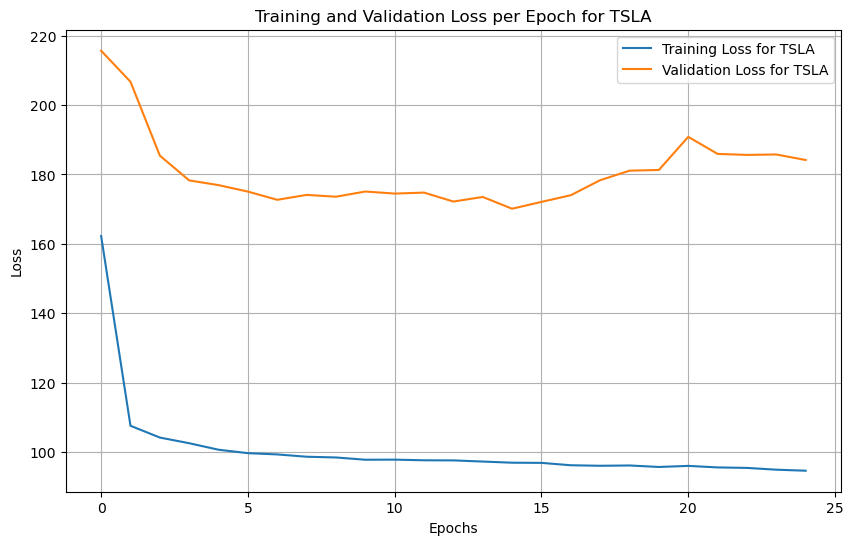

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_TSLA, label='Training Loss for TSLA')
plt.plot(val_losses_TSLA, label='Validation Loss for TSLA')
plt.title('Training and Validation Loss per Epoch for TSLA')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## RMSE for TSLA

In [26]:
test(model_TSLA, X_test_TSLA_tensor, y_test_TSLA_tensor)

Root Mean Squared Error (RMSE): 12.716267585754395


12.716268

# Train and test model for AAPL

In [27]:
model_AAPL = BaseNN(X_train_AAPL_tensor.shape[1], [128, 128], 'leaky_relu')

# Weight decay for L2 regularization
weight_decay = 1e-6
optimizer = torch.optim.Adam(model_AAPL.parameters(), lr=0.001, weight_decay=weight_decay)
loss_fn = nn.MSELoss()

In [28]:
model_AAPL, train_losses_AAPL, val_losses_AAPL = train(model_AAPL, X_train_AAPL_tensor, y_train_AAPL_tensor, X_val_AAPL_tensor, y_val_AAPL_tensor, loss_fn, optimizer, 100, 32)

Epoch 1/100 - Loss: 0.6493483781814575, Val Loss: 44.847251892089844
Epoch 2/100 - Loss: 0.10234221071004868, Val Loss: 37.927947998046875
Epoch 3/100 - Loss: 0.01304763276129961, Val Loss: 43.27386474609375
Epoch 4/100 - Loss: 0.1321849375963211, Val Loss: 46.56121063232422
Epoch 5/100 - Loss: 0.07497379183769226, Val Loss: 47.85300064086914
Epoch 6/100 - Loss: 0.038256801664829254, Val Loss: 46.953704833984375
Epoch 7/100 - Loss: 0.007210710551589727, Val Loss: 41.39629364013672
Epoch 8/100 - Loss: 0.1057877168059349, Val Loss: 38.20830535888672
Epoch 9/100 - Loss: 0.023214465007185936, Val Loss: 36.24909210205078
Epoch 10/100 - Loss: 0.1075524315237999, Val Loss: 35.53549575805664
Epoch 11/100 - Loss: 0.06614483147859573, Val Loss: 35.54018783569336
Epoch 12/100 - Loss: 0.015846647322177887, Val Loss: 42.679969787597656
Epoch 13/100 - Loss: 0.08601455390453339, Val Loss: 35.018524169921875
Epoch 14/100 - Loss: 0.17191585898399353, Val Loss: 35.15006637573242
Epoch 15/100 - Loss: 0.1

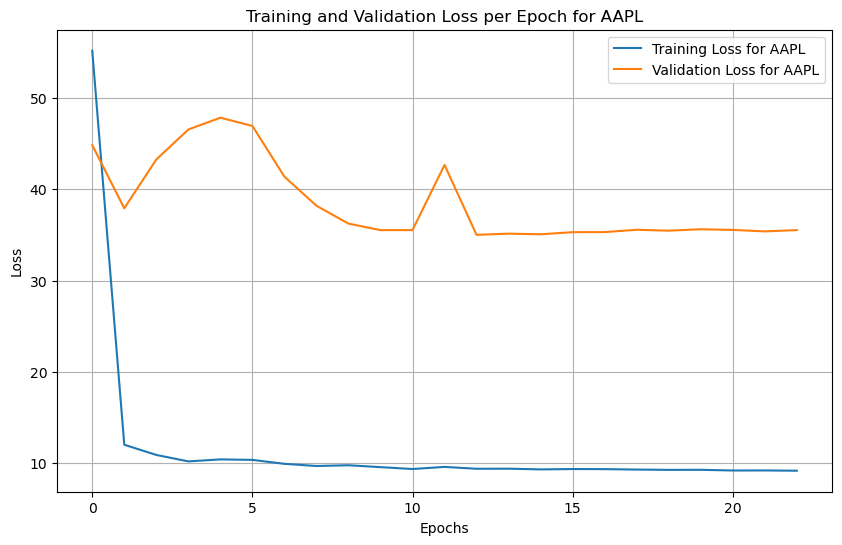

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_AAPL, label='Training Loss for AAPL')
plt.plot(val_losses_AAPL, label='Validation Loss for AAPL')
plt.title('Training and Validation Loss per Epoch for AAPL')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## RMSE for AAPL

In [30]:
test(model_AAPL, X_test_AAPL_tensor, y_test_AAPL_tensor)

Root Mean Squared Error (RMSE): 4.034947395324707


4.0349474

# Train and test model for NVDA

In [31]:
model_NVDA = BaseNN(X_train_NVDA_tensor.shape[1], [128, 128], 'leaky_relu')

# Weight decay for L2 regularization
weight_decay = 1e-6
optimizer = torch.optim.Adam(model_NVDA.parameters(), lr=0.001, weight_decay=weight_decay)
loss_fn = nn.MSELoss()

In [32]:
model_NVDA, train_losses_NVDA, val_losses_NVDA = train(model_NVDA, X_train_NVDA_tensor, y_train_NVDA_tensor, X_val_NVDA_tensor, y_val_NVDA_tensor, loss_fn, optimizer, 100, 32)

Epoch 1/100 - Loss: 8.19725227355957, Val Loss: 813.4305419921875
Epoch 2/100 - Loss: 14.570976257324219, Val Loss: 635.0573120117188
Epoch 3/100 - Loss: 12.215679168701172, Val Loss: 623.6893920898438
Epoch 4/100 - Loss: 17.245689392089844, Val Loss: 658.5140991210938
Epoch 5/100 - Loss: 14.559423446655273, Val Loss: 669.2105102539062
Epoch 6/100 - Loss: 12.563297271728516, Val Loss: 666.947265625
Epoch 7/100 - Loss: 8.562870979309082, Val Loss: 654.8234252929688
Epoch 8/100 - Loss: 6.283475875854492, Val Loss: 641.9869384765625
Epoch 9/100 - Loss: 5.874760150909424, Val Loss: 634.0049438476562
Epoch 10/100 - Loss: 4.069833278656006, Val Loss: 611.6654052734375
Epoch 11/100 - Loss: 3.4334237575531006, Val Loss: 603.8296508789062
Epoch 12/100 - Loss: 2.4804465770721436, Val Loss: 597.669921875
Epoch 13/100 - Loss: 2.3735172748565674, Val Loss: 592.4000854492188
Epoch 14/100 - Loss: 2.474311590194702, Val Loss: 586.5309448242188
Epoch 15/100 - Loss: 2.562211036682129, Val Loss: 586.1162

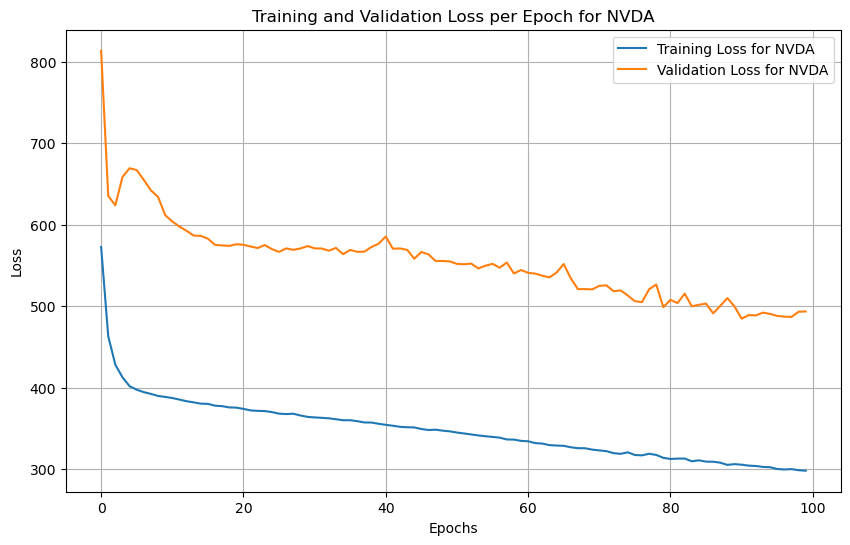

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_NVDA, label='Training Loss for NVDA')
plt.plot(val_losses_NVDA, label='Validation Loss for NVDA')
plt.title('Training and Validation Loss per Epoch for NVDA')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## RMSE for NVDA

In [34]:
test(model_NVDA, X_test_NVDA_tensor, y_test_NVDA_tensor)

Root Mean Squared Error (RMSE): 23.618427276611328


23.618427